# Support Vector Regression (SVR)

## Importing the libraries

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [100]:
# dataset = pd.read_csv('/content/drive/My Drive/DS-Solar/DS_G33_Solar.csv')
dataset = xr.open_mfdataset('/content/drive/My Drive/DS-Solar/test/*.nc', parallel=True)
df = dataset.to_dataframe().reset_index()

In [120]:

# df = dataset
d = df.loc[(df['ens'] == 0 )  ] # selecting 1 ensemble and 14 locations
# d['DateTime'] = d['intValidTime'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d%H')) # adding formated date time
d['DateTime'] = pd.to_datetime(d['intValidTime'], format='%Y%m%d%H')
d = d[['DateTime'] + [x for x in d if x not in ['DateTime']]] # moving DateTime col to beginning
d = d.drop(['ens', 'fhour', 'lat', 'lon', 'time', 'intTime', 'intValidTime'], axis = 1) # removing all metadata cols after selection
d = d.sort_values('DateTime') # sorting by Date Time
d = d.reset_index().drop(['index'], axis = 1) # removing old index
d['Net_Downward_Rad_Flux'] = np.sum(d[['Downward_Short-Wave_Rad_Flux', 'Downward_Long-Wave_Rad_Flux']], 
                            axis=1) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [121]:
X = d.iloc[:, 3:-1].values
y = d.iloc[:, -1].values

In [122]:
# dataset = pd.read_csv('ENTER_THE_NAME_OF_YOUR_DATASET_HERE.csv')
# X = dataset.iloc[:, :-1].values
# y = dataset.iloc[:, -1].values

In [123]:
y = y.reshape(len(y),1)

In [ ]:
display(d)

## Splitting the dataset into the Training set and Test set

In [124]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Feature Scaling

In [125]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
y_train = sc_y.fit_transform(y_train)

## Training the SVR model on the Training set

In [147]:
# from h2o4gpu.svm import SVR
# testing to speed up SVR, above library uses GPU acceleration

#regular svr which has complexity as polynomial with power 4
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [126]:
# %pip install --force-reinstall -I h2o4gpu

In [139]:

# # linear svr apporximation for large datasets
# from sklearn.svm import LinearSVR as SVR
# regressor = SVR(max_iter=2000 )
# regressor.fit(X_train, y_train)


## Predicting the Test set results

In [140]:
yy = X_test
display(yy.shape)
# display(yy)
# display(y_pred.shape)
# yyy = yy.reshape(1, -13)
# display(yyy.shape)


(1796, 13)

In [141]:
display(sc_y.inverse_transform(regressor.predict(sc_X.transform(X_test)).reshape(-1,1)))

array([[1249.88],
       [ 429.53],
       [1406.75],
       ...,
       [1200.58],
       [ 599.34],
       [ 365.34]])

In [142]:
y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(X_test)).reshape(-1,1))
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1249.88 1239.  ]
 [ 429.53  422.  ]
 [1406.75 1405.53]
 ...
 [1200.58 1204.  ]
 [ 599.34  599.  ]
 [ 365.34  394.  ]]


## Evaluating the Model Performance

In [143]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.9959608046760007

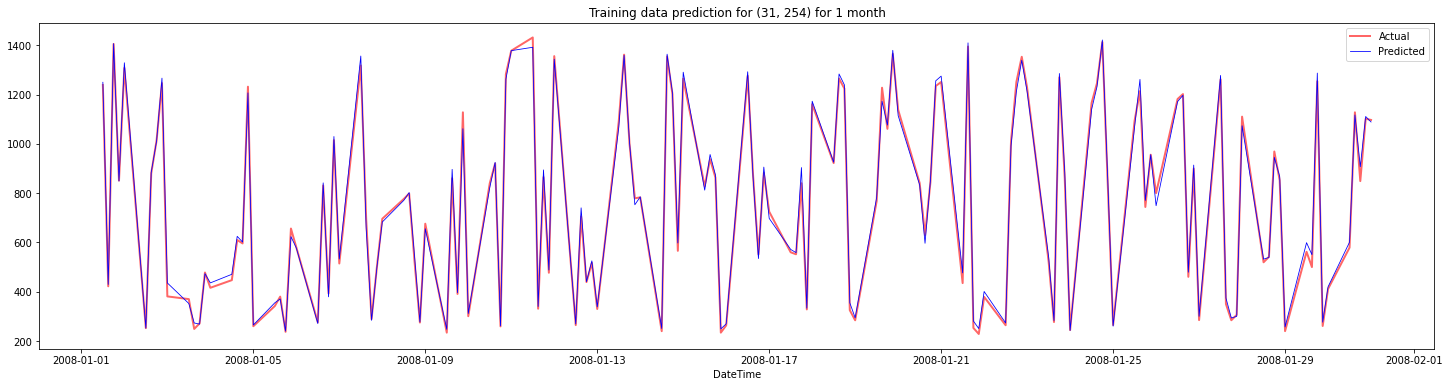

In [144]:
DateTime = d['DateTime'].iloc[:150]
y_test_vis = y_test[:150]
y_pred_vis = y_pred[:150]
# DateTime.shape
plt.figure(figsize=(25,6))
plt.plot(DateTime, y_test_vis, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(DateTime, y_pred_vis, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('DateTime')
plt.title("Training data prediction for (31, 254) for 1 month")
plt.show()

In [145]:
from sklearn.metrics import mean_squared_error
# compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 23.352601


In [146]:
display(d.info())
display(df['lat'].unique())
display(df['lon'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8980 entries, 0 to 8979
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   DateTime                               8980 non-null   datetime64[ns]
 1   Downward_Long-Wave_Rad_Flux            8980 non-null   float32       
 2   Downward_Short-Wave_Rad_Flux           8980 non-null   float32       
 3   Maximum_temperature                    8980 non-null   float32       
 4   Minimum_temperature                    8980 non-null   float32       
 5   Precipitable_water                     8980 non-null   float32       
 6   Pressure                               8980 non-null   float32       
 7   Specific_humidity_height_above_ground  8980 non-null   float32       
 8   Temperature_height_above_ground        8980 non-null   float32       
 9   Temperature_surface                    8980 non-null   float32 

None

array([31., 32., 33., 34., 35., 36., 37., 38., 39.])

array([254., 255., 256., 257., 258., 259., 260., 261., 262., 263., 264.,
       265., 266., 267., 268., 269.])